# CAPSTONE PROJECT - Segmenting and Clustering Neighborhoods in Toronto

In [1]:
import pandas as pd
import numpy as np
import urllib3
from bs4 import BeautifulSoup
import requests
from pandas.io.json import json_normalize
# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

We store the wikipedia URL in a variable

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

Then, we use a PoolManager object from urllib3 package to open an http connection. <br/>
With the 'GET' parameter and the url, the request method retrievs the content of the web page. <br/>
Finally I use *BeautifulSoup* to parse and manipulate the html content.

In [3]:
http = urllib3.PoolManager()
response = http.request('GET', url)
soup = BeautifulSoup(response.data.decode('utf-8'))

C:\Users\hantu\Anaconda3\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Initialization of 3 lists that will store each furtur columns of the dataframe 

In [4]:
codes_list=[]
borough_list=[]
neighborhood_list=[]

Then, I use BeautifulSoup object to find all the html tags containing 'td' in order to focus on the results from the table of the wikipedia page. <br/> 
The results is like an array of "Td" tag. <br/>
I noticed that the structure is always the same, first the PostalCode, then the Borough, then the Neighborhood and finally an empty result. Thererfore I initialize a *i* counter that I reinitialize to 1 every tag.<br/> 
- First tag's text is sotred in the PostalCodes list 
- Second tag's text is sotred in the Borough list
- Third tag's text is sotred in the Neighborhood list
- Fourth tag reinitializes the counter to 1


In [5]:
i=1
for tag in soup.table.find_all('td'):
    if i == 1:
        codes_list.append(tag.text)
    if i == 2:
        borough_list.append(tag.text)
    if i == 3: 
        neighborhood_list.append(tag.text)
    i = i+1
    if i==4:
        i=1

Cleaning the data to remove a "\n" character

In [6]:
neighborhood_list = [n.replace('\n', '') for n in neighborhood_list]

Creating a pandas DataFrame for each list...

In [7]:
dfC = pd.DataFrame(codes_list, columns=["PostalCode"])
dfB = pd.DataFrame(borough_list, columns=["Borough"])
dfN = pd.DataFrame(neighborhood_list, columns=["Neighborhood"])

...that I concat afterwards to create the main dataframe : df

In [8]:
df = pd.concat([dfC, dfB, dfN], axis=1).reindex(dfC.index)

Filter the values not to keep boroughs with "Not assigned" value

In [9]:
df = df[df['Borough']!="Not assigned"]

In [10]:
df.reset_index(drop=True, inplace=True)

For the Neighborhoods that have a "Not assigned" value, I assign the value of the corresponding Borough using df.loc

In [11]:
df.loc[df['Neighborhood'] == "Not assigned", 'Neighborhood'] = df.loc[df['Neighborhood'] == "Not assigned", 'Borough']

Here, I group the Neighborhoods having the same PostalCode and the same Borough, they are concatenated on a single row using a ', ' separator and converted back to a dataframe. <br />
Eventually, we reset the index to have a clean indexed dataframe.

In [12]:
df = df.groupby(['PostalCode', 'Borough'])['Neighborhood'].apply(lambda tags: ', '.join(tags)).to_frame()

In [13]:
df.reset_index(inplace=True)

In [14]:
df

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
...,...,...,...
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Kingsview Village, Martin Grove Gardens, Richv..."
101,M9V,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ..."


In [15]:
df.shape 

(103, 3)

In [16]:
coor = pd.read_csv("http://cocl.us/Geospatial_data")

In [17]:
coor.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [18]:
df = df.merge(coor, how='inner', left_on='PostalCode', right_on='Postal Code')

In [19]:
df = df.drop(['Postal Code'], axis=1)

In [20]:
df

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188
99,M9P,Etobicoke,Westmount,43.696319,-79.532242
100,M9R,Etobicoke,"Kingsview Village, Martin Grove Gardens, Richv...",43.688905,-79.554724
101,M9V,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ...",43.739416,-79.588437


### Creating a map of Toronto

In [21]:
import folium
import geopy

In [22]:
address = 'Toronto, ON, Canada'

geolocator = geopy.Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [23]:
map_tor = folium.Map(location=[latitude, longitude], zoom_start=10)

Adding marker to the map

In [24]:
# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tor)  
    
map_tor

#### FourSquare credential definition

In [25]:
CLIENT_ID = 'JO31W52NKMLMEQBPQ3GSRBK3FKRXIIJLIFKSRNDDTC5K1Q23' # your Foursquare ID
CLIENT_SECRET = 'XVGAMH0OCJG03ALF5ONIWJN3CJ5TOMKTST0ECRVRKQVCVHNL' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JO31W52NKMLMEQBPQ3GSRBK3FKRXIIJLIFKSRNDDTC5K1Q23
CLIENT_SECRET:XVGAMH0OCJG03ALF5ONIWJN3CJ5TOMKTST0ECRVRKQVCVHNL


### Neighborhood exploration

In [26]:
df.loc[0, 'Neighborhood']

'Rouge, Malvern'

Get the neighborhood's latitude and longitude values.

In [27]:
neighborhood_latitude = df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Rouge, Malvern are 43.806686299999996, -79.19435340000001.


#### Now, let's get the top 100 venues that are in Rouge, Malvern within a radius of 500 meters.

First, let's create the GET request URL. Name your URL **url**.

In [28]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=JO31W52NKMLMEQBPQ3GSRBK3FKRXIIJLIFKSRNDDTC5K1Q23&client_secret=XVGAMH0OCJG03ALF5ONIWJN3CJ5TOMKTST0ECRVRKQVCVHNL&v=20180605&ll=43.806686299999996,-79.19435340000001&radius=500&limit=100'

Then send the GET request and examine the resutls

In [29]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e2848dfbae9a20026e9a5de'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Malvern',
  'headerFullLocation': 'Malvern, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 1,
  'suggestedBounds': {'ne': {'lat': 43.8111863045, 'lng': -79.18812958073042},
   'sw': {'lat': 43.80218629549999, 'lng': -79.2005772192696}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bb6b9446edc76b0d771311c',
       'name': "Wendy's",
       'location': {'crossStreet': 'Morningside & Sheppard',
        'lat': 43.80744841934756,
        'lng': -79.19905558052072,
        'labeledLatLngs': [{'label': 'display'

In [30]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [31]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Wendy's,Fast Food Restaurant,43.807448,-79.199056


And how many venues were returned by Foursquare?

In [32]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

1 venues were returned by Foursquare.


## Explore Neighborhoods in Downtown Toronto

List of the Neighborhoods in Downtown Toronto:

In [33]:
df_downT = df[df['Borough'] == 'Downtown Toronto']
df_downT

,PostalCode,Borough,Neighborhood,Latitude,Longitude
50,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529
51,M4X,Downtown Toronto,"Cabbagetown, St. James Town",43.667967,-79.367675
52,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
53,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
54,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937
55,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
56,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
57,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
58,M5H,Downtown Toronto,"Adelaide, King, Richmond",43.650571,-79.384568
59,M5J,Downtown Toronto,"Harbourfront East, Toronto Islands, Union Station",43.640816,-79.381752


#### Function to repeat the same process to all the neighborhoods in Downtown Toronto

In [34]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

We run the above function on each neighborhood and create a new dataframe called *DonwT_venues*.

In [35]:
DonwT_venues = getNearbyVenues(names=df_downT['Neighborhood'],
                                   latitudes=df_downT['Latitude'],
                                   longitudes=df_downT['Longitude']
                                  )

Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Queen's Park


Checking the size of the dataframe

In [36]:
print(DonwT_venues.shape)
DonwT_venues.head()

(1312, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rosedale,43.679563,-79.377529,Rosedale Park,43.682328,-79.378934,Playground
1,Rosedale,43.679563,-79.377529,Whitney Park,43.682036,-79.373788,Park
2,Rosedale,43.679563,-79.377529,Alex Murray Parkette,43.678300,-79.382773,Park
3,Rosedale,43.679563,-79.377529,Milkman's Lane,43.676352,-79.373842,Trail
4,"Cabbagetown, St. James Town",43.667967,-79.367675,Cranberries,43.667843,-79.369407,Diner


Let's check how many venues were returned for each neighborhood

In [37]:
DonwT_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Berczy Park,58,58,58,58,58,58
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",16,16,16,16,16,16
"Cabbagetown, St. James Town",44,44,44,44,44,44
Central Bay Street,84,84,84,84,84,84
"Chinatown, Grange Park, Kensington Market",87,87,87,87,87,87
Christie,17,17,17,17,17,17
Church and Wellesley,85,85,85,85,85,85
"Commerce Court, Victoria Hotel",100,100,100,100,100,100


#### Let's find out how many unique categories can be curated from all the returned venues

In [38]:
print('There are {} uniques categories.'.format(len(DonwT_venues['Venue Category'].unique())))

There are 205 uniques categories.


##  Analyze Each Neighborhood


In [39]:
# one hot encoding
DownT_onehot = pd.get_dummies(DonwT_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
DownT_onehot['Neighborhood'] = DonwT_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [DownT_onehot.columns[-1]] + list(DownT_onehot.columns[:-1])
DownT_onehot = DownT_onehot[fixed_columns]

DownT_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [40]:
DownT_onehot.shape

(1312, 205)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [41]:
DownT_grouped = DownT_onehot.groupby('Neighborhood').mean().reset_index()
DownT_grouped

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,"Adelaide, King, Richmond",0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.020000,...,0.000000,0.00,0.00,0.00,0.020000,0.000000,0.000000,0.000000,0.000000,0.01
1,Berczy Park,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,...,0.000000,0.00,0.00,0.00,0.017241,0.000000,0.000000,0.000000,0.000000,0.00
2,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.000000,0.000000,0.0625,0.0625,0.0625,0.125,0.125,0.125,0.000000,...,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
3,"Cabbagetown, St. James Town",0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.022727,...,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
4,Central Bay Street,0.011905,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.011905,...,0.000000,0.00,0.00,0.00,0.011905,0.000000,0.000000,0.011905,0.000000,0.00
5,"Chinatown, Grange Park, Kensington Market",0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,...,0.000000,0.00,0.00,0.00,0.045977,0.000000,0.057471,0.011494,0.000000,0.00
6,Christie,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,...,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
7,Church and Wellesley,0.011765,0.011765,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.011765,...,0.011765,0.00,0.00,0.00,0.000000,0.000000,0.011765,0.000000,0.011765,0.00
8,"Commerce Court, Victoria Hotel",0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.020000,...,0.000000,0.00,0.00,0.00,0.020000,0.000000,0.000000,0.010000,0.000000,0.00
9,"Design Exchange, Toronto Dominion Centre",0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.020000,...,0.000000,0.00,0.00,0.01,0.010000,0.000000,0.000000,0.010000,0.000000,0.00


In [42]:
DownT_grouped.shape

(19, 205)

In [43]:
num_top_venues = 5

for hood in DownT_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = DownT_grouped[DownT_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
            venue  freq
0     Coffee Shop  0.07
1            Café  0.04
2      Steakhouse  0.04
3             Bar  0.04
4  Cosmetics Shop  0.03


----Berczy Park----
          venue  freq
0   Coffee Shop  0.09
1  Cocktail Bar  0.05
2      Beer Bar  0.03
3    Steakhouse  0.03
4   Cheese Shop  0.03


----CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara----
              venue  freq
0    Airport Lounge  0.12
1   Airport Service  0.12
2  Airport Terminal  0.12
3     Boat or Ferry  0.06
4   Harbor / Marina  0.06


----Cabbagetown, St. James Town----
         venue  freq
0  Coffee Shop  0.07
1   Restaurant  0.07
2       Bakery  0.05
3  Pizza Place  0.05
4         Café  0.05


----Central Bay Street----
                venue  freq
0         Coffee Shop  0.15
1                Café  0.05
2  Italian Restaurant  0.05
3        Burger Joint  0.04
4      Ice Cream Shop  0.04


----Chinatown, Grange Park, Kensi

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [44]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [45]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = DownT_grouped['Neighborhood']

for ind in np.arange(DownT_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(DownT_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Bar,Steakhouse,Café,Hotel,Restaurant,Asian Restaurant,Cosmetics Shop,Thai Restaurant,Burger Joint
1,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Cheese Shop,Seafood Restaurant,Steakhouse,Beer Bar,Café,Farmers Market,Eastern European Restaurant
2,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Lounge,Airport Service,Airport Terminal,Plane,Harbor / Marina,Sculpture Garden,Boat or Ferry,Rental Car Location,Bar,Boutique
3,"Cabbagetown, St. James Town",Coffee Shop,Restaurant,Pub,Italian Restaurant,Bakery,Pizza Place,Café,Chinese Restaurant,Breakfast Spot,Plaza
4,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Japanese Restaurant,Sandwich Place,Burger Joint,Chinese Restaurant,Juice Bar,Ice Cream Shop,Bubble Tea Shop


## Cluster Neighborhoods

### First we will evaluate the optimal number of clusters k

In [46]:
DownT_grouped_clustering = DownT_grouped.drop('Neighborhood', 1)

For each k value, we will initialise k-means and use the inertia attribute to identify the sum of squared distances of samples to the nearest cluster centre.

In [47]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(DownT_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

Let's check the result using the "Elbow Method"

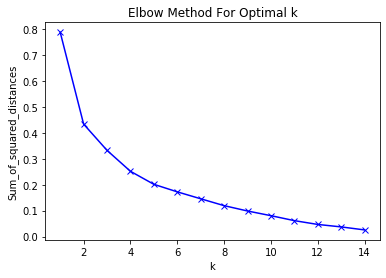

In [48]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#### We can see on the above graph that the optimal k is 4, based on the elbow it forms. <br/>
Lets define *k*-means to cluster the neighborhood into 4 clusters.

In [49]:
# set number of clusters
kclusters = 4

DownT_grouped_clustering = DownT_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(DownT_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 2, 1, 1, 1, 3, 1, 1, 1])

Merging che cluster labels with the initial Downtown Toronto dataframe

In [50]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

DownT_merged = df_downT

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
DownT_merged = DownT_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

DownT_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
50,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,0,Park,Playground,Trail,Deli / Bodega,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Discount Store
51,M4X,Downtown Toronto,"Cabbagetown, St. James Town",43.667967,-79.367675,1,Coffee Shop,Restaurant,Pub,Italian Restaurant,Bakery,Pizza Place,Café,Chinese Restaurant,Breakfast Spot,Plaza
52,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,1,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Restaurant,Gay Bar,Gym,Pub,Men's Store,Mediterranean Restaurant,Hotel
53,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636,1,Coffee Shop,Bakery,Park,Pub,Mexican Restaurant,Café,Restaurant,Breakfast Spot,Event Space,Hotel
54,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,1,Coffee Shop,Clothing Store,Cosmetics Shop,Café,Middle Eastern Restaurant,Japanese Restaurant,Fast Food Restaurant,Bakery,Italian Restaurant,Restaurant


Let's visualize the results on the Toronto map

In [51]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(DownT_merged['Latitude'], DownT_merged['Longitude'], DownT_merged['Neighborhood'], DownT_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Cluster Examination

#### Cluster 1

In [52]:
DownT_merged.loc[DownT_merged['Cluster Labels'] == 0, DownT_merged.columns[[1] + list(range(5, DownT_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
50,Downtown Toronto,0,Park,Playground,Trail,Deli / Bodega,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Discount Store


#### Cluster 2

In [53]:
DownT_merged.loc[DownT_merged['Cluster Labels'] == 1, DownT_merged.columns[[1] + list(range(5, DownT_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
51,Downtown Toronto,1,Coffee Shop,Restaurant,Pub,Italian Restaurant,Bakery,Pizza Place,Café,Chinese Restaurant,Breakfast Spot,Plaza
52,Downtown Toronto,1,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Restaurant,Gay Bar,Gym,Pub,Men's Store,Mediterranean Restaurant,Hotel
53,Downtown Toronto,1,Coffee Shop,Bakery,Park,Pub,Mexican Restaurant,Café,Restaurant,Breakfast Spot,Event Space,Hotel
54,Downtown Toronto,1,Coffee Shop,Clothing Store,Cosmetics Shop,Café,Middle Eastern Restaurant,Japanese Restaurant,Fast Food Restaurant,Bakery,Italian Restaurant,Restaurant
55,Downtown Toronto,1,Coffee Shop,Restaurant,Café,Cocktail Bar,Clothing Store,Italian Restaurant,Hotel,Bakery,Beer Bar,Cosmetics Shop
56,Downtown Toronto,1,Coffee Shop,Cocktail Bar,Bakery,Cheese Shop,Seafood Restaurant,Steakhouse,Beer Bar,Café,Farmers Market,Eastern European Restaurant
57,Downtown Toronto,1,Coffee Shop,Café,Italian Restaurant,Japanese Restaurant,Sandwich Place,Burger Joint,Chinese Restaurant,Juice Bar,Ice Cream Shop,Bubble Tea Shop
58,Downtown Toronto,1,Coffee Shop,Bar,Steakhouse,Café,Hotel,Restaurant,Asian Restaurant,Cosmetics Shop,Thai Restaurant,Burger Joint
59,Downtown Toronto,1,Coffee Shop,Aquarium,Café,Hotel,Restaurant,Italian Restaurant,Brewery,Fried Chicken Joint,Scenic Lookout,History Museum
60,Downtown Toronto,1,Coffee Shop,Café,Hotel,Bar,Restaurant,Gastropub,Steakhouse,Seafood Restaurant,Lounge,American Restaurant


#### Cluster 3

In [54]:
DownT_merged.loc[DownT_merged['Cluster Labels'] == 2, DownT_merged.columns[[1] + list(range(5, DownT_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
68,Downtown Toronto,2,Airport Lounge,Airport Service,Airport Terminal,Plane,Harbor / Marina,Sculpture Garden,Boat or Ferry,Rental Car Location,Bar,Boutique


#### Cluster 4

In [55]:
DownT_merged.loc[DownT_merged['Cluster Labels'] == 3, DownT_merged.columns[[1] + list(range(5, DownT_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
75,Downtown Toronto,3,Grocery Store,Café,Park,Athletics & Sports,Gas Station,Italian Restaurant,Diner,Nightclub,Candy Store,Restaurant
